# Load loop matrices and stats

In [1]:
import cooler
import numpy as np
import pandas as pd
from scipy.sparse import triu
from scipy.stats import pearsonr, zscore, norm
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
leg2name = {xx:yy for xx,yy in zip(leg, legname)}


In [3]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'cnu': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['cnu'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']


In [4]:
group_name = 'neu'

In [5]:
ctgroup = []
if '_' in group_name:
    for xx in group_name.split('_'):
        ctgroup.append(leg[xx])
else:
    for xx in leg[group_name]:
        ctgroup.append([xx])
        

In [6]:
leg = pd.Index(np.concatenate(ctgroup))
legname = leg.map(leg2name)
res = 10000

In [7]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/'
outdir = f'/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/diff/{group_name}/'

In [8]:
chrom_size_path = f'{indir}hg38_with_chrl.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)


## Load Loop Position and ANOVA

In [9]:
loopall = [pd.read_csv(f'{indir}/{ct}/{ct}/{ct}.loop.bedpe', sep='\t', index_col=None, header=None) for ct in leg]
loopall = pd.concat(loopall, axis=0)
loopall = loopall.drop([6], axis=1).drop_duplicates(subset=[0,1,4]).sort_values([0,1,4])
loopall = pd.concat([loopall[(loopall[0]==c).values] for c in chrom_sizes.index[:-1]])
loopall.index = np.arange(loopall.shape[0])
loopall


,0,1,2,3,4,5
0,chr1,900000,910000,chr1,960000,970000
1,chr1,900000,910000,chr1,970000,980000
2,chr1,910000,920000,chr1,970000,980000
3,chr1,910000,920000,chr1,980000,990000
4,chr1,910000,920000,chr1,990000,1000000
...,...,...,...,...,...,...
2873610,chr22,50570000,50580000,chr22,50670000,50680000
2873611,chr22,50580000,50590000,chr22,50670000,50680000
2873612,chr22,50590000,50600000,chr22,50670000,50680000
2873613,chr22,50600000,50610000,chr22,50670000,50680000


In [10]:
loopall.to_csv(f'{outdir}merged_loop.bedpe', sep='\t', index=False, header=False)
loopall.to_hdf(f'{outdir}merged_loop.hdf', key='data')


In [11]:
for c in chrom_sizes.index[:-1]:
    loopfilter = (loopall[0]==c)
    looptmp = loopall.loc[loopfilter, [1,4]].values // res
    for matrix in ['Q', 'E', 'T']:
        cool = cooler.Cooler(f'{outdir}majortype_{matrix}pv.cool')
        pv = triu(cool.matrix(balance=False, sparse=True).fetch(c)).tocsr()
        loopall.loc[loopfilter, f'{matrix}anova'] = pv[(looptmp[:,0], looptmp[:,1])].A1
    print(c)


chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [12]:
loopall.to_hdf(f'{outdir}merged_loop.hdf', key='data')


## Load Loop Q

In [13]:
loopall = pd.read_hdf(f'{outdir}merged_loop.hdf', key='data')
loopall

,0,1,2,3,4,5,Qanova,Eanova,Tanova
0,chr1,900000,910000,chr1,960000,970000,3.750881,6.097476,2.068213
1,chr1,900000,910000,chr1,970000,980000,3.322128,6.001146,2.007495
2,chr1,910000,920000,chr1,970000,980000,3.293559,5.439024,2.229271
3,chr1,910000,920000,chr1,980000,990000,2.704021,5.648575,2.289167
4,chr1,910000,920000,chr1,990000,1000000,2.819877,5.675182,1.669268
...,...,...,...,...,...,...,...,...,...
2873610,chr22,50570000,50580000,chr22,50670000,50680000,1.646674,11.822375,1.625390
2873611,chr22,50580000,50590000,chr22,50670000,50680000,2.256175,11.555016,1.335000
2873612,chr22,50590000,50600000,chr22,50670000,50680000,3.531459,11.165133,1.195543
2873613,chr22,50600000,50610000,chr22,50670000,50680000,4.896728,11.926161,2.028210


In [14]:
def load_Q(ct, m):
    tmp = []
    cool_file = cooler.Cooler(f'{indir}{ct}/{ct}/{ct}.{m}.cool').matrix(balance=False, sparse=True)
    for c in chrom_sizes.index[:-1]:
        mat = cool_file.fetch(c).tocsr()
        tmp.append(mat[(loopall.loc[loopall[0]==c, 1].values // res, loopall.loc[loopall[0]==c, 4].values // res)].A1)
        # print(ct, c)
    return [ct, np.concatenate(tmp)]


In [15]:
cpu = 5
with ProcessPoolExecutor(cpu) as executor:
    futures = []
    for xx in leg:
        future = executor.submit(
            load_Q,
            ct=xx,
            m='Q'
        )
        futures.append(future)

    loopq = []
    for future in as_completed(futures):
        tmp = future.result()
        loopq.append(pd.DataFrame(tmp[1], columns=[tmp[0]]))
        print(f'{tmp[0]} finished')
        

L23_IT finished
L6_IT_Car3 finished
L5_IT finished
L6_IT finished
L4_IT finished
L56_NP finished
L6_CT finished
L6b finished
Amy finished
Lamp5 finished
Lamp5_LHX6 finished
Sncg finished
Vip finished
Pvalb finished
Pvalb_ChC finished
Sst finished
CHD7 finished
MSN_D1 finished
MSN_D2 finished
Foxp2 finished
SubCtx finished


In [16]:
loopq = pd.concat(loopq, axis=1)
loopq = loopq[leg]


In [17]:
loopq.to_hdf(f'{outdir}loop_Q.hdf', key='data')


In [18]:
cpu = 5
with ProcessPoolExecutor(cpu) as executor:
    futures = []
    for xx in leg:
        future = executor.submit(
            load_Q,
            ct=xx,
            m='T'
        )
        futures.append(future)

    loopt = []
    for future in as_completed(futures):
        tmp = future.result()
        loopt.append(pd.DataFrame(tmp[1], columns=[tmp[0]]))
        print(f'{tmp[0]} finished')
        

L5_IT finished
L23_IT finished
L6_IT finished
L4_IT finished
L6_IT_Car3 finished
L56_NP finished
L6_CT finished
L6b finished
Amy finished
Lamp5 finished
Lamp5_LHX6 finished
Sncg finished
Vip finished
Pvalb finished
Pvalb_ChC finished
Sst finished
CHD7 finished
MSN_D1 finished
MSN_D2 finished
Foxp2 finished
SubCtx finished


In [19]:
loopt = pd.concat(loopt, axis=1)
loopt = loopt[leg]


In [20]:
loopt.to_hdf(f'{outdir}loop_T.hdf', key='data')


In [21]:
loopq = pd.read_hdf(f'{outdir}loop_Q.hdf', key='data')
loopt = pd.read_hdf(f'{outdir}loop_T.hdf', key='data')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


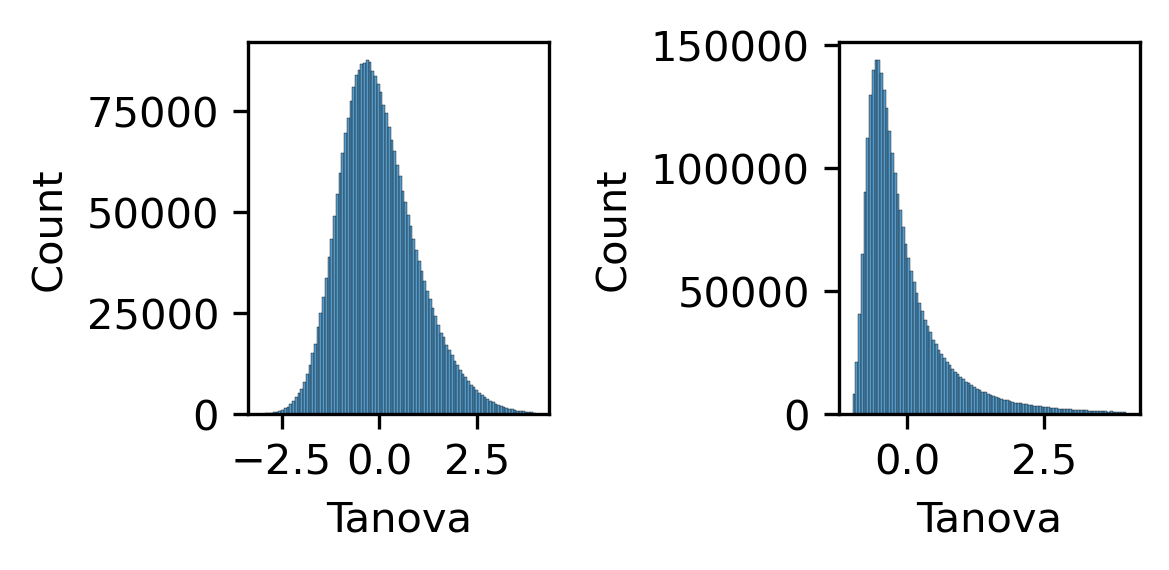

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)
ax = axes[0]
sns.histplot(zscore(np.log10(loopall['Tanova'])), bins=100, binrange=(-3,4), ax=ax)
ax = axes[1]
sns.histplot(zscore(loopall['Tanova']), bins=100, binrange=(-1,4), ax=ax)
plt.tight_layout()


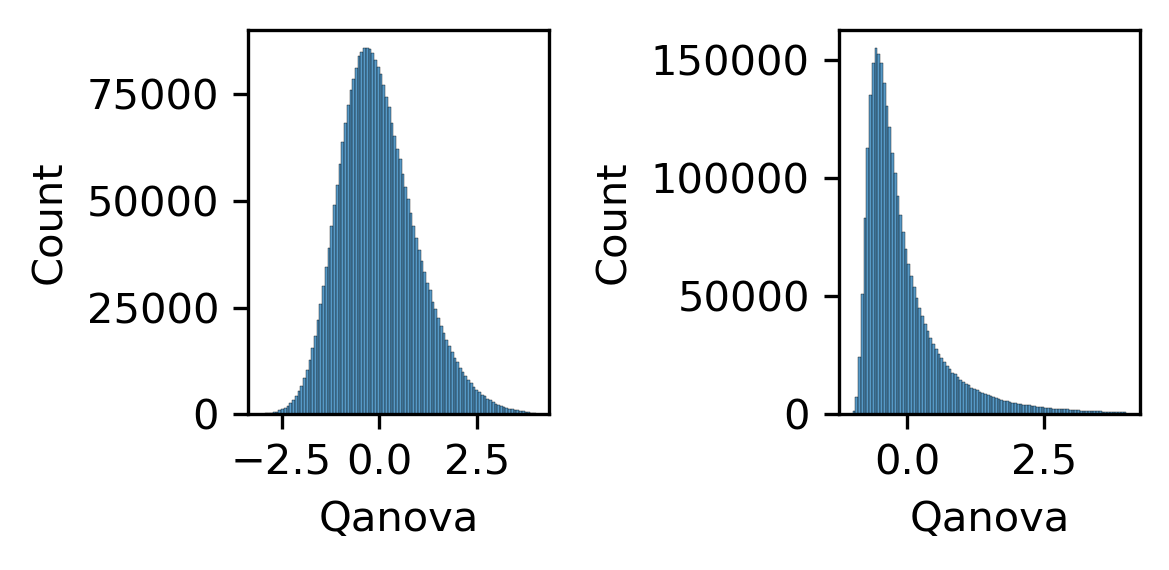

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)
ax = axes[0]
sns.histplot(zscore(np.log10(loopall['Qanova'])), bins=100, binrange=(-3,4), ax=ax)
ax = axes[1]
sns.histplot(zscore(loopall['Qanova']), bins=100, binrange=(-1,4), ax=ax)
plt.tight_layout()


In [24]:
thres1 = norm.isf(0.025)
thres2 = norm.isf(0.15)
print(thres1, thres2)


1.9599639845400545 1.0364333894937898


In [25]:
selb = ((zscore(loopall['Qanova'])>thres2) & (zscore(loopall['Tanova'])>thres2))


In [26]:
tmpq = loopq.loc[selb].values
tmpq = zscore(tmpq, axis=1)


In [27]:
tmpt = loopt.loc[selb].values
tmpt = zscore(tmpt, axis=1)


In [28]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmpq)), 2000, False)


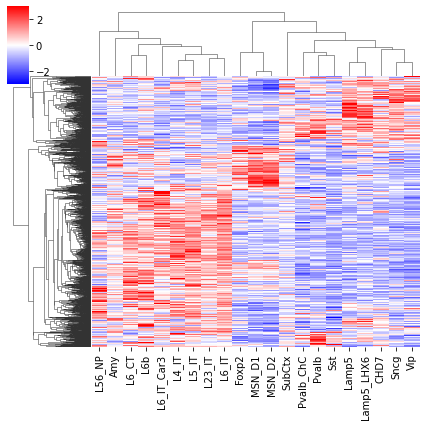

In [29]:
cg = sns.clustermap(tmpq[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [30]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

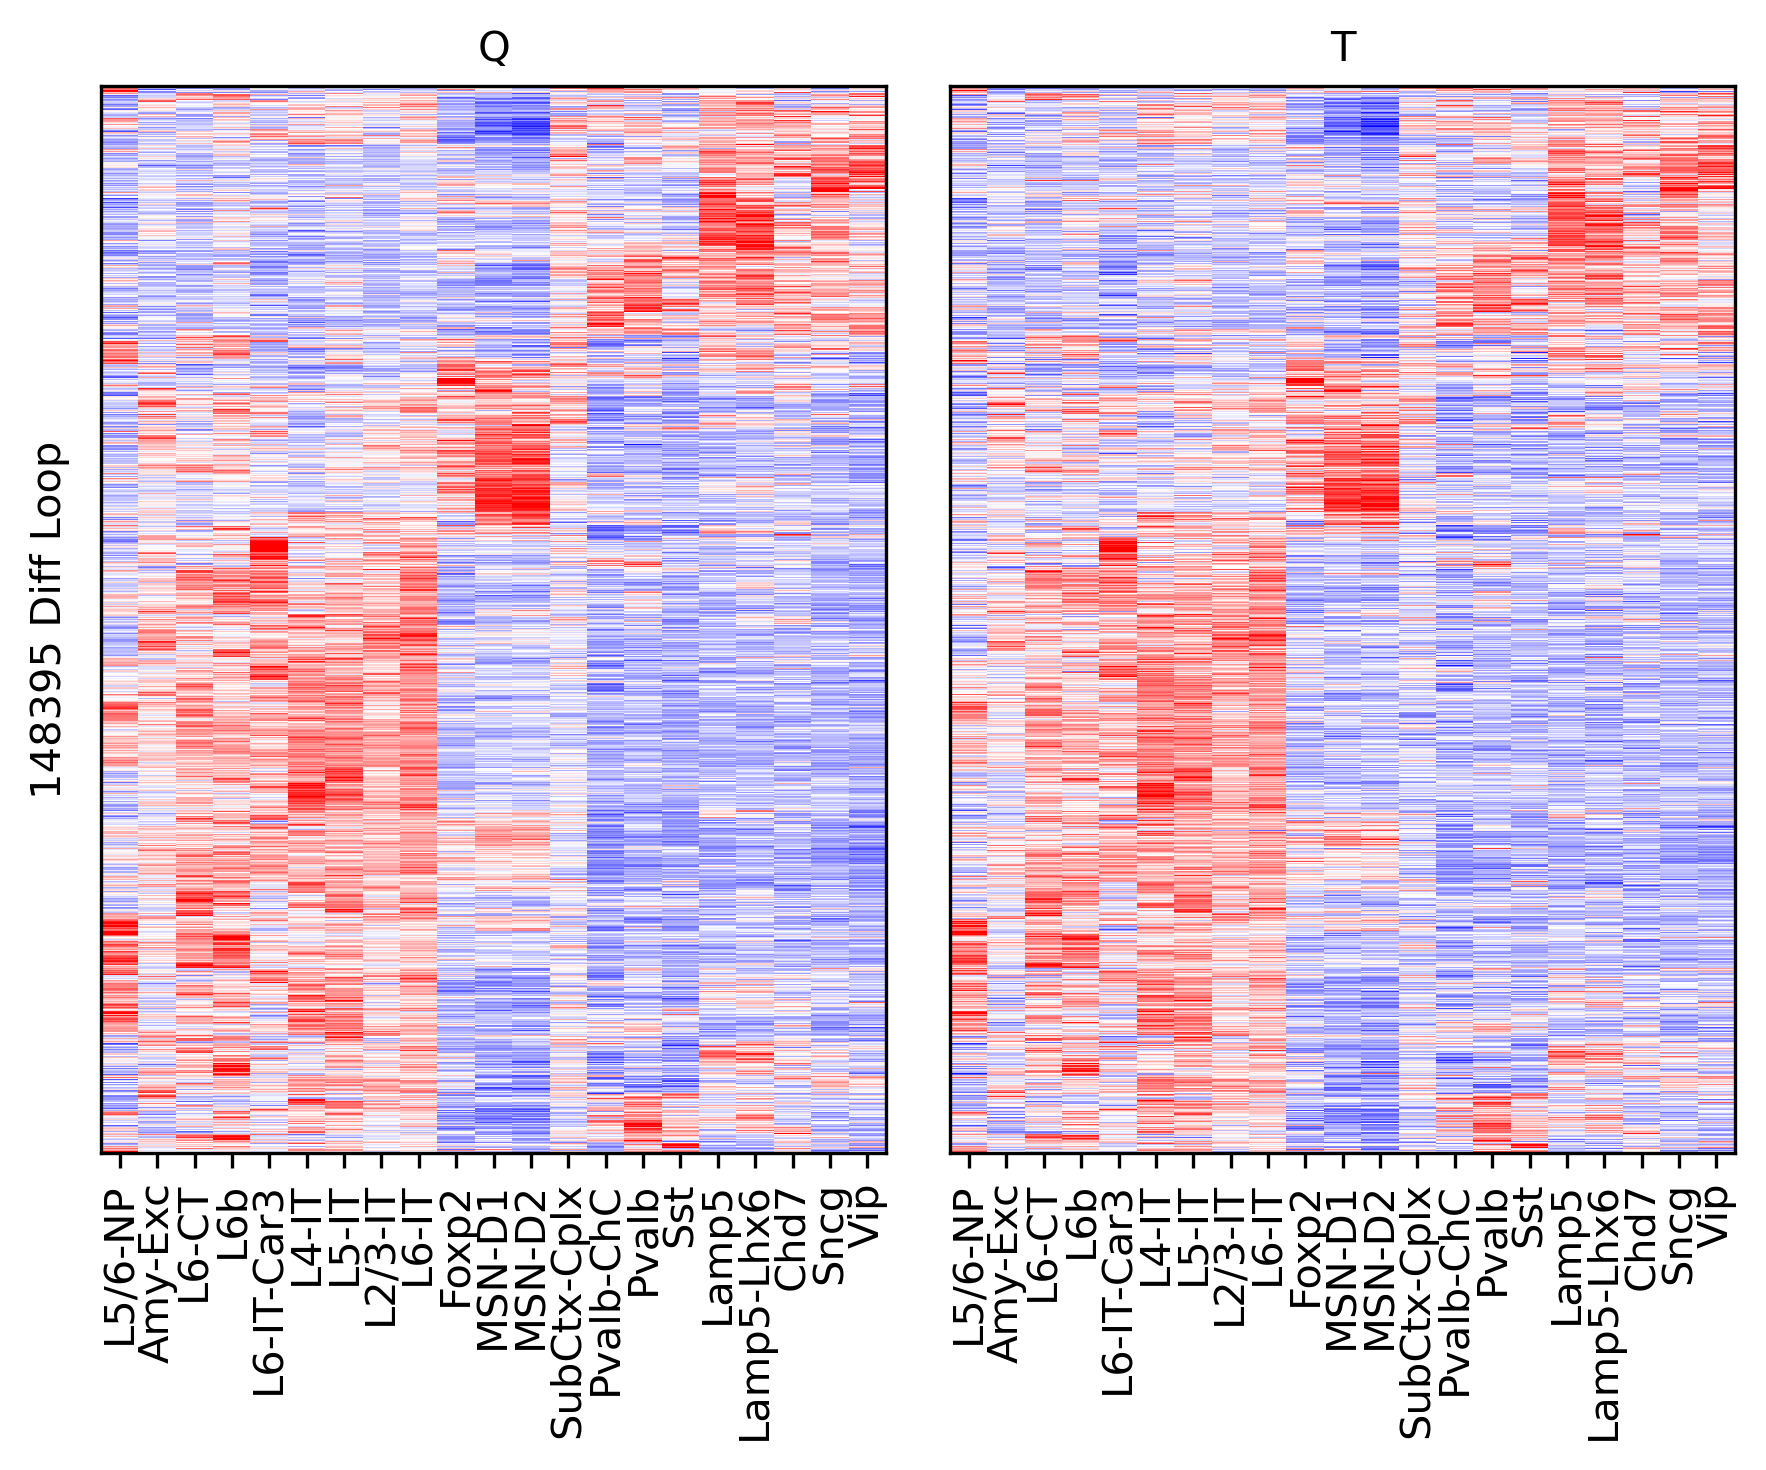

In [31]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6, 5), dpi=300)

ax = axes[0]
ax.imshow(tmpq[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Q', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{tmpq.shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmpt[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('T', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)

plt.tight_layout()
